<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-3-public/blob/main/Course%202%20-%20Custom%20Training%20loops%2C%20Gradients%20and%20Distributed%20Training/Week%202%20-%20Simple%20Custom%20Training/C2_W2_Lab_2_training-categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST using Custom Training Loop
In this ungraded lab, you will build a custom training loop including a validation loop so as to train a model on the [Fashion MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) dataset.

## Imports

In [36]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

import time

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Load and Preprocess Data
You will load the [Fashion MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) dataset using Tensorflow Datasets. This dataset has 28 x 28 grayscale images of articles of clothing belonging to 10 clases.

Here you are going to use the training and testing splits of the data. Testing split will be used for validation.

In [37]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=False)

In [38]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Next, you normalize the images by dividing them by 255.0 so as to make the pixels fall in the range (0, 1). You also reshape the data so as to flatten the 28 x 28 pixel array into a flattened 784 pixel array.

In [39]:
!ls -l ./data/

total 8
drwxr-xr-x 3 root root 4096 Jun 28 19:34 downloads
drwxr-xr-x 3 root root 4096 Jun 28 19:35 fashion_mnist


In [40]:
def format_image(data):
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [41]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

Now you shuffle and batch your training and test datasets before feeding them to the model.

In [42]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

test =  test_data.batch(batch_size=batch_size)

## Define the Model
You are using a simple model in this example. You use Keras Functional API to connect two dense layers. The final layer is a softmax that outputs one of the 10 classes since this is a multi class classification problem.

In [43]:
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

## Define Optimizer and Loss Function

You have chosen `adam` optimizer and sparse categorical crossentropy loss for this example.

In [44]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

## Define Metrics

You will also define metrics so that your training loop can update and display them. Here you are using `SparseCategoricalAccuracy`defined in `tf.keras.metrics` since the problem at hand is a multi class classification problem.

In [45]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Building Training Loop
In this section you build your training loop consisting of training and validation sequences.

The core of training is using the model to calculate the logits on specific set of inputs and compute loss (in this case **sparse categorical crossentropy**) by comparing the predicted outputs to the true outputs. You then update the trainable weights using the optimizer algorithm chosen. Optimizer algorithm requires your computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

You use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

In [46]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)

  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return logits, loss_value

This function performs training during one epoch. You run through all batches of training data in each epoch to make updates to trainable weights using your previous function. You can see that we also call update_state on your metrics to accumulate the value of your metrics.
You are displaying a progress bar to indicate completion of training in each epoch. Here you use tqdm for displaying the progress bar.

In [47]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)

      losses.append(loss_value)

      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

At the end of each epoch you have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [48]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

Next you define the training loop that runs through the training samples repeatedly over a fixed number of epochs. Here you combine the functions you built earlier to establish the following flow:
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

**Note** : You also calculate the training and validation losses for the whole epoch at the end of the epoch.

In [49]:

# start = time.time()
# end = time.time()
# print(end - start)

train_model_start = time.time()

model = base_model()

# Iterate over epochs.
epochs = 10
#epochs = 50
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  train_epoch_start = time.time()

  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))

  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

  train_epoch_end = time.time()
  print(f"train epoch duration -> {((train_epoch_end - train_epoch_start)/60):.2f}m")


train_model_end = time.time()
print(f"train model duration -> {((train_model_end - train_model_start)/60):.2f}m")


Start of epoch 0


Training loss for step 937: 0.6778: 100%|██████████| 938/938 



 Epoch 0: Train loss: 0.5452  Validation Loss: 0.4625, Train Accuracy: 0.8102, Validation Accuracy 0.8374
train epoch duration -> 0.52m
Start of epoch 1


Training loss for step 937: 0.1744: 100%|██████████| 938/938 



 Epoch 1: Train loss: 0.3915  Validation Loss: 0.4173, Train Accuracy: 0.8597, Validation Accuracy 0.8536
train epoch duration -> 0.50m
Start of epoch 2


Training loss for step 937: 0.3230: 100%|██████████| 938/938 



 Epoch 2: Train loss: 0.3537  Validation Loss: 0.3921, Train Accuracy: 0.8723, Validation Accuracy 0.8601
train epoch duration -> 0.76m
Start of epoch 3


Training loss for step 937: 0.1616: 100%|██████████| 938/938 



 Epoch 3: Train loss: 0.3301  Validation Loss: 0.3828, Train Accuracy: 0.8797, Validation Accuracy 0.8648
train epoch duration -> 0.77m
Start of epoch 4


Training loss for step 937: 0.3972: 100%|██████████| 938/938 



 Epoch 4: Train loss: 0.3123  Validation Loss: 0.3532, Train Accuracy: 0.8849, Validation Accuracy 0.8769
train epoch duration -> 0.76m
Start of epoch 5


Training loss for step 937: 0.2854: 100%|██████████| 938/938 



 Epoch 5: Train loss: 0.2981  Validation Loss: 0.3593, Train Accuracy: 0.8902, Validation Accuracy 0.8741
train epoch duration -> 0.77m
Start of epoch 6


Training loss for step 937: 0.1024: 100%|██████████| 938/938 



 Epoch 6: Train loss: 0.2856  Validation Loss: 0.3414, Train Accuracy: 0.8946, Validation Accuracy 0.8802
train epoch duration -> 0.75m
Start of epoch 7


Training loss for step 937: 0.1966: 100%|██████████| 938/938 



 Epoch 7: Train loss: 0.2772  Validation Loss: 0.3562, Train Accuracy: 0.8972, Validation Accuracy 0.8785
train epoch duration -> 0.76m
Start of epoch 8


Training loss for step 937: 0.2238: 100%|██████████| 938/938 



 Epoch 8: Train loss: 0.2656  Validation Loss: 0.3549, Train Accuracy: 0.9007, Validation Accuracy 0.8798
train epoch duration -> 0.74m
Start of epoch 9


Training loss for step 937: 0.0686: 100%|██████████| 938/938 



 Epoch 9: Train loss: 0.2586  Validation Loss: 0.3528, Train Accuracy: 0.9044, Validation Accuracy 0.8772
train epoch duration -> 0.79m
Start of epoch 10


Training loss for step 937: 0.1200: 100%|██████████| 938/938 



 Epoch 10: Train loss: 0.2521  Validation Loss: 0.3468, Train Accuracy: 0.9058, Validation Accuracy 0.8823
train epoch duration -> 0.75m
Start of epoch 11


Training loss for step 937: 0.1570: 100%|██████████| 938/938 



 Epoch 11: Train loss: 0.2413  Validation Loss: 0.3511, Train Accuracy: 0.9095, Validation Accuracy 0.8843
train epoch duration -> 0.47m
Start of epoch 12


Training loss for step 937: 0.4915: 100%|██████████| 938/938 



 Epoch 12: Train loss: 0.2365  Validation Loss: 0.3638, Train Accuracy: 0.9111, Validation Accuracy 0.8788
train epoch duration -> 0.77m
Start of epoch 13


Training loss for step 937: 0.1492: 100%|██████████| 938/938 



 Epoch 13: Train loss: 0.2302  Validation Loss: 0.3640, Train Accuracy: 0.9127, Validation Accuracy 0.8831
train epoch duration -> 0.46m
Start of epoch 14


Training loss for step 937: 0.1869: 100%|██████████| 938/938 



 Epoch 14: Train loss: 0.2223  Validation Loss: 0.3568, Train Accuracy: 0.9170, Validation Accuracy 0.8860
train epoch duration -> 0.46m
Start of epoch 15


Training loss for step 937: 0.2307: 100%|██████████| 938/938 



 Epoch 15: Train loss: 0.2181  Validation Loss: 0.3604, Train Accuracy: 0.9175, Validation Accuracy 0.8804
train epoch duration -> 0.76m
Start of epoch 16


Training loss for step 937: 0.1786: 100%|██████████| 938/938 



 Epoch 16: Train loss: 0.2128  Validation Loss: 0.3756, Train Accuracy: 0.9193, Validation Accuracy 0.8763
train epoch duration -> 0.76m
Start of epoch 17


Training loss for step 937: 0.3050: 100%|██████████| 938/938 



 Epoch 17: Train loss: 0.2093  Validation Loss: 0.3549, Train Accuracy: 0.9211, Validation Accuracy 0.8848
train epoch duration -> 0.75m
Start of epoch 18


Training loss for step 937: 0.1761: 100%|██████████| 938/938 



 Epoch 18: Train loss: 0.2017  Validation Loss: 0.3703, Train Accuracy: 0.9240, Validation Accuracy 0.8766
train epoch duration -> 0.52m
Start of epoch 19


Training loss for step 937: 0.1890: 100%|██████████| 938/938 



 Epoch 19: Train loss: 0.1989  Validation Loss: 0.3725, Train Accuracy: 0.9250, Validation Accuracy 0.8842
train epoch duration -> 0.76m
Start of epoch 20


Training loss for step 937: 0.2681: 100%|██████████| 938/938 



 Epoch 20: Train loss: 0.1937  Validation Loss: 0.3695, Train Accuracy: 0.9271, Validation Accuracy 0.8852
train epoch duration -> 0.54m
Start of epoch 21


Training loss for step 937: 0.3536: 100%|██████████| 938/938 



 Epoch 21: Train loss: 0.1898  Validation Loss: 0.3921, Train Accuracy: 0.9280, Validation Accuracy 0.8823
train epoch duration -> 0.55m
Start of epoch 22


Training loss for step 937: 0.1210: 100%|██████████| 938/938 



 Epoch 22: Train loss: 0.1865  Validation Loss: 0.4001, Train Accuracy: 0.9296, Validation Accuracy 0.8793
train epoch duration -> 0.81m
Start of epoch 23


Training loss for step 937: 0.1420: 100%|██████████| 938/938 



 Epoch 23: Train loss: 0.1830  Validation Loss: 0.4009, Train Accuracy: 0.9297, Validation Accuracy 0.8814
train epoch duration -> 0.79m
Start of epoch 24


Training loss for step 937: 0.1958: 100%|██████████| 938/938 



 Epoch 24: Train loss: 0.1786  Validation Loss: 0.3850, Train Accuracy: 0.9331, Validation Accuracy 0.8839
train epoch duration -> 0.77m
Start of epoch 25


Training loss for step 937: 0.0965: 100%|██████████| 938/938 



 Epoch 25: Train loss: 0.1740  Validation Loss: 0.4080, Train Accuracy: 0.9341, Validation Accuracy 0.8786
train epoch duration -> 0.76m
Start of epoch 26


Training loss for step 937: 0.1290: 100%|██████████| 938/938 



 Epoch 26: Train loss: 0.1742  Validation Loss: 0.4110, Train Accuracy: 0.9342, Validation Accuracy 0.8820
train epoch duration -> 0.75m
Start of epoch 27


Training loss for step 937: 0.0806: 100%|██████████| 938/938 



 Epoch 27: Train loss: 0.1677  Validation Loss: 0.4106, Train Accuracy: 0.9365, Validation Accuracy 0.8836
train epoch duration -> 0.75m
Start of epoch 28


Training loss for step 937: 0.2064: 100%|██████████| 938/938 



 Epoch 28: Train loss: 0.1674  Validation Loss: 0.3970, Train Accuracy: 0.9361, Validation Accuracy 0.8839
train epoch duration -> 0.74m
Start of epoch 29


Training loss for step 937: 0.4726: 100%|██████████| 938/938 



 Epoch 29: Train loss: 0.1629  Validation Loss: 0.4024, Train Accuracy: 0.9384, Validation Accuracy 0.8825
train epoch duration -> 0.51m
Start of epoch 30


Training loss for step 937: 0.5038: 100%|██████████| 938/938 



 Epoch 30: Train loss: 0.1599  Validation Loss: 0.4388, Train Accuracy: 0.9401, Validation Accuracy 0.8792
train epoch duration -> 0.50m
Start of epoch 31


Training loss for step 937: 0.1187: 100%|██████████| 938/938 



 Epoch 31: Train loss: 0.1570  Validation Loss: 0.4249, Train Accuracy: 0.9409, Validation Accuracy 0.8821
train epoch duration -> 0.75m
Start of epoch 32


Training loss for step 937: 0.2021: 100%|██████████| 938/938 



 Epoch 32: Train loss: 0.1521  Validation Loss: 0.4530, Train Accuracy: 0.9421, Validation Accuracy 0.8808
train epoch duration -> 0.49m
Start of epoch 33


Training loss for step 937: 0.0666: 100%|██████████| 938/938 



 Epoch 33: Train loss: 0.1525  Validation Loss: 0.4441, Train Accuracy: 0.9426, Validation Accuracy 0.8788
train epoch duration -> 0.48m
Start of epoch 34


Training loss for step 937: 0.1196: 100%|██████████| 938/938 



 Epoch 34: Train loss: 0.1491  Validation Loss: 0.4330, Train Accuracy: 0.9436, Validation Accuracy 0.8852
train epoch duration -> 0.53m
Start of epoch 35


Training loss for step 937: 0.0143: 100%|██████████| 938/938 



 Epoch 35: Train loss: 0.1473  Validation Loss: 0.4394, Train Accuracy: 0.9436, Validation Accuracy 0.8845
train epoch duration -> 0.46m
Start of epoch 36


Training loss for step 937: 0.1261: 100%|██████████| 938/938 



 Epoch 36: Train loss: 0.1455  Validation Loss: 0.4630, Train Accuracy: 0.9458, Validation Accuracy 0.8781
train epoch duration -> 0.76m
Start of epoch 37


Training loss for step 937: 0.0640: 100%|██████████| 938/938 



 Epoch 37: Train loss: 0.1422  Validation Loss: 0.4475, Train Accuracy: 0.9463, Validation Accuracy 0.8842
train epoch duration -> 0.46m
Start of epoch 38


Training loss for step 937: 0.0727: 100%|██████████| 938/938 



 Epoch 38: Train loss: 0.1390  Validation Loss: 0.4656, Train Accuracy: 0.9478, Validation Accuracy 0.8762
train epoch duration -> 0.48m
Start of epoch 39


Training loss for step 937: 0.0216: 100%|██████████| 938/938 



 Epoch 39: Train loss: 0.1364  Validation Loss: 0.4805, Train Accuracy: 0.9481, Validation Accuracy 0.8841
train epoch duration -> 0.49m
Start of epoch 40


Training loss for step 937: 0.0734: 100%|██████████| 938/938 



 Epoch 40: Train loss: 0.1386  Validation Loss: 0.4688, Train Accuracy: 0.9481, Validation Accuracy 0.8807
train epoch duration -> 0.77m
Start of epoch 41


Training loss for step 937: 0.1056: 100%|██████████| 938/938 



 Epoch 41: Train loss: 0.1326  Validation Loss: 0.4925, Train Accuracy: 0.9502, Validation Accuracy 0.8841
train epoch duration -> 0.48m
Start of epoch 42


Training loss for step 937: 0.0892: 100%|██████████| 938/938 



 Epoch 42: Train loss: 0.1285  Validation Loss: 0.4930, Train Accuracy: 0.9519, Validation Accuracy 0.8794
train epoch duration -> 0.48m
Start of epoch 43


Training loss for step 937: 0.0213: 100%|██████████| 938/938 



 Epoch 43: Train loss: 0.1293  Validation Loss: 0.5231, Train Accuracy: 0.9514, Validation Accuracy 0.8779
train epoch duration -> 0.50m
Start of epoch 44


Training loss for step 937: 0.0809: 100%|██████████| 938/938 



 Epoch 44: Train loss: 0.1297  Validation Loss: 0.4804, Train Accuracy: 0.9514, Validation Accuracy 0.8803
train epoch duration -> 0.47m
Start of epoch 45


Training loss for step 937: 0.0460: 100%|██████████| 938/938 



 Epoch 45: Train loss: 0.1244  Validation Loss: 0.5374, Train Accuracy: 0.9526, Validation Accuracy 0.8781
train epoch duration -> 0.54m
Start of epoch 46


Training loss for step 937: 0.0807: 100%|██████████| 938/938 



 Epoch 46: Train loss: 0.1277  Validation Loss: 0.5097, Train Accuracy: 0.9514, Validation Accuracy 0.8839
train epoch duration -> 0.47m
Start of epoch 47


Training loss for step 937: 0.1221: 100%|██████████| 938/938 



 Epoch 47: Train loss: 0.1199  Validation Loss: 0.5057, Train Accuracy: 0.9552, Validation Accuracy 0.8806
train epoch duration -> 0.50m
Start of epoch 48


Training loss for step 937: 0.0798: 100%|██████████| 938/938 



 Epoch 48: Train loss: 0.1205  Validation Loss: 0.5108, Train Accuracy: 0.9549, Validation Accuracy 0.8833
train epoch duration -> 0.48m
Start of epoch 49


Training loss for step 937: 0.0801: 100%|██████████| 938/938 



 Epoch 49: Train loss: 0.1175  Validation Loss: 0.5111, Train Accuracy: 0.9555, Validation Accuracy 0.8816
train epoch duration -> 0.79m
train model duration -> 31.46m


In [53]:
!ls -l

total 8
drwxr-xr-x 4 root root 4096 Jun 28 19:34 data
drwxr-xr-x 1 root root 4096 Jun 27 13:35 sample_data


In [54]:
model_save_path = "./data/basicmodel/1/"
tf.saved_model.save(model, model_save_path)

In [59]:
!ls -l data/basicmodel/1

total 84
drwxr-xr-x 2 root root  4096 Jun 28 20:56 assets
-rw-r--r-- 1 root root    57 Jun 28 20:56 fingerprint.pb
-rw-r--r-- 1 root root 69646 Jun 28 20:56 saved_model.pb
drwxr-xr-x 2 root root  4096 Jun 28 20:56 variables


In [58]:
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('./basicmodel.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('./data/basicmodel/1/', zipf)
zipf.close()

start time 10:25
end time 10:32
duration: 7m

# capture training duration
import time

start = time.time()

end = time.time()

print(end - start)

# save model
model_save_path = "./tmp/mymodel/1/"

tf.saved_model.save(model, model_save_path)

## Evaluate Model

### Plots for Evaluation
You plot the progress of loss as training proceeds over number of epochs.

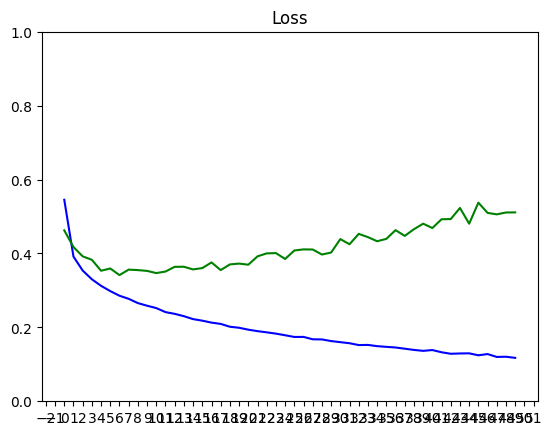

In [50]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

This function displays a row of images with their predictions and true labels.

In [51]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)]

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

You make predictions on the test dataset and plot the images with their true and predicted values.

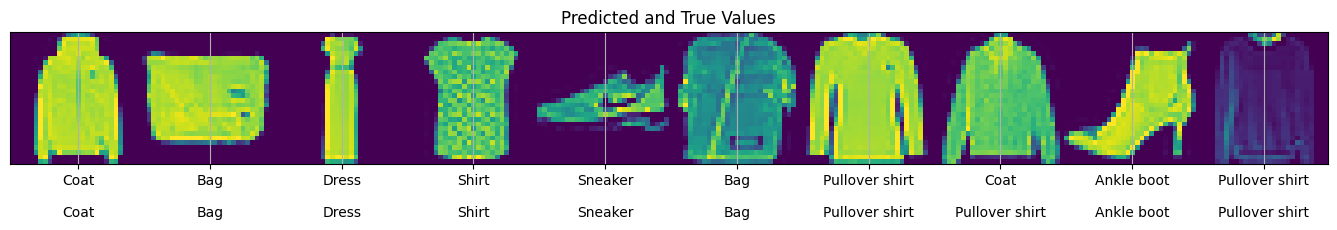

In [52]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)